In [6]:
import wandb

In [7]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("API_key")
!wandb login $api_key

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
hyperparams = dict(
    filters = 64,
#     kernel_1 = (5,5),
#     kernel_2 = (3,3),
#     padding = 'same',
#     pooling = (2,2),
#     lr = 0.001,
#     wd = 0.0,
#     lr_schedule = 'RLR',    # cos, cyclic, step decay
#     optimizer = 'Adam+SWA',     # RMS
#     dense_units = 256,
#     activation = 'elu',      # elu, LeakyRelu
    dropout = 0.25,
    dropout_f = 0.5,
#     batch_size = BATCH_SIZE,
#     epochs = EPOCHS,
)

wandb.init(project="apple", config=hyperparams)
config = wandb.config

wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [9]:
!pip install -q efficientnet

In [10]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
import efficientnet.tfkeras as efn
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.applications import ResNet152V2, InceptionResNetV2, InceptionV3, Xception, VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# TPU Config

In [11]:
AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path("plant-pathology-2021-fgvc8")


# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set.
    # On Kaggle this is always the case.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)
# Configuration
EPOCHS = 50
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

REPLICAS:  1


# Load Labels

In [12]:
def format_path(st):
    return GCS_DS_PATH +"/train_images/" + st
import os
train = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
train=train.sample(frac=1)#[:2000]
sub = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')

X_indices = train.image.apply(format_path).values

train_labels = train.loc[:, 'healthy':].values

labelslist = list(i.replace(" ","__") for i in set(train.labels.values))

labelslist = ['healthy', 'scab', 'rust', 'complex', 'frog_eye_leaf_spot', 'powdery_mildew', 'scab__frog_eye_leaf_spot__complex', 'scab__frog_eye_leaf_spot', 'frog_eye_leaf_spot__complex', 'rust__frog_eye_leaf_spot' ,  'powdery_mildew__complex','rust__complex']

print(labelslist)
for lb in labelslist:
    train[lb] = train.labels.apply(lambda e: (lb in e.replace(" ","__"))*1)
y_targets = train[labelslist].values  # changed
# print(train_labels)
print(y_targets.shape)

['healthy', 'scab', 'rust', 'complex', 'frog_eye_leaf_spot', 'powdery_mildew', 'scab__frog_eye_leaf_spot__complex', 'scab__frog_eye_leaf_spot', 'frog_eye_leaf_spot__complex', 'rust__frog_eye_leaf_spot', 'powdery_mildew__complex', 'rust__complex']
(18632, 12)


In [13]:
def print_target_counts(y, label):
    _, y_counts = np.unique(y, return_counts=True)
    y_total = len(y)
    y_0_count = y_counts[0]
    y_1_count = y_counts[1]
    y_1_percent = y_1_count / y_total * 100.0
    print("{0:10s}: Total={1:5d}, 0={2:5d}, 1={3:3d}, ratio of 1={4:.2f}%".format(
        label, y_total, y_0_count, y_1_count, y_1_percent))

In [14]:
from sklearn.model_selection import train_test_split

# Split the generated indices and target values by train_test_split().
# The ratio of target values should be kept in the splitted datasets.
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    X_indices, y_targets, test_size=0.15, stratify=y_targets, random_state=53)

print_target_counts(train_labels, "Training")
print_target_counts(valid_labels, "Validation")

Training  : Total=15837, 0=171393, 1=18651, ratio of 1=117.77%
Validation: Total= 2795, 0=30249, 1=3291, ratio of 1=117.75%


# Image Resizing

In [15]:
image_size = 800

def decode_image(filename, label=None, image_size=(image_size, image_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0

#     h, w = 2672, 4000# image.shape[-3], image.shape[-2]
#     e= 500
#     image = tf.image.crop_to_bounding_box(image, e+0, e+(w - h) // 2, h-e, h-e)
    image = tf.image.resize(image, image_size)
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [16]:
train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

# test_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices(test_paths)
#     .map(decode_image, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
# )

Learning rate schedule: 0.0001 to 0.0001 to 0.0001


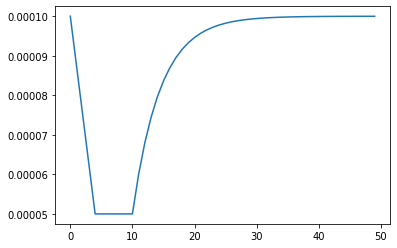

In [17]:
LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [18]:
from tensorflow.keras.layers import Layer

class SoftProbField(Layer):
    def __init__(self, **kwargs):
        super(SoftProbField, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SoftProbField, self).build(input_shape)  # Be sure to call this at the end
    def call(self, x):
        h = x[:, 0]
        ss = x[:, 1]
        rr = x[:, 2]
        cc = x[:, 3]
        ff = x[:, 4]
        pp = x[:, 5]

        s=(1-h)*ss*(1-rr)*(1-cc)*(1-ff)*(1-pp)
        f=(1-h)*(1-ss)*(1-rr)*(1-cc)*ff*(1-pp)
        c=(1-h)*(1-ss)*(1-rr)*cc*(1-ff)*(1-pp)
        r=(1-h)*(1-ss)*rr*(1-cc)*(1-ff)*(1-pp)
        p=(1-h)*(1-ss)*(1-rr)*(1-cc)*(1-ff)*pp
        
        v1 =(1-h)*ss*(1-rr)*cc*ff*(1-pp)             # scab frog_eye_leaf_spot complex
        v2 =(1-h)*ss*(1-rr)*(1-cc)*ff*(1-pp)         # scab frog_eye_leaf_spot
        v3 =(1-h)*(1-ss)*(1-rr)*cc*ff*(1-pp)         # frog_eye_leaf_spot complex
        v4 =(1-h)*(1-ss)*rr*(1-cc)*ff*(1-pp)         # rust frog_eye_leaf_spot
        v5 =(1-h)*(1-ss)*(1-rr)*cc*(1-ff)*pp         # powdery_mildew complex
        v6 =(1-h)*(1-ss)*rr*cc*(1-ff)*(1-pp)         # rust complex
        


        return tf.stack([h,s,r,c,f,p,v1,v2,v3,v4,v5,v6], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 4)

# Model Architecture

In [19]:
# with strategy.scope():
#     model = tf.keras.Sequential([
#         InceptionResNetV2(
#             input_shape=(image_size, image_size, 3),
#             weights='imagenet',
#             include_top=False
#         ),
#         L.GlobalAveragePooling2D(),
#         L.Dense(6, activation='softmax'), 
#         SoftProbField()
#     ])
 
#     model.compile(
#         optimizer = 'adam',
#         loss = 'categorical_crossentropy',
#         metrics=['categorical_accuracy']
#     )
#     model.summary()

In [20]:

# STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

# history = model.fit(
#     train_dataset, 
#     epochs= EPOCHS, 
#     callbacks=[lr_callback],
#     steps_per_epoch=STEPS_PER_EPOCH,
#     #validation_data=valid_dataset
# )

# model.save('my_model1.h5') 

In [21]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [22]:
with strategy.scope():
    model2 = tf.keras.Sequential([
        efn.EfficientNetB7(
            input_shape=(image_size, image_size, 3),
            weights='noisy-student',
            include_top=False
        ),
#         L.GlobalMaxPooling2D(),
        L.GlobalAveragePooling2D(),
        L.Dense(6, activation='sigmoid'),
        SoftProbField()
#         L.GlobalMaxPooling2D(),
#         L.Dense(12, activation='softmax')
    ])
        
    model2.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy','acc',f1_m,precision_m, recall_m]
    )
    model2.summary()

258072576/258068648 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 25, 25, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 15366     
_________________________________________________________________
soft_prob_field (SoftProbFie (None, 12)                0         
Total params: 64,113,046
Trainable params: 63,802,326
Non-trainable params: 310,720
_________________________________________________________________


In [23]:
from keras.callbacks import ModelCheckpoint
ch_p_den = ModelCheckpoint(filepath="model_den.h5", monitor='val_loss', save_weights_only=True,
                                                 verbose=1)

In [24]:
!ls ../input/

k  plant-pathology-2021-fgvc8


In [ ]:
STEPS_PER_EPOCH = train_labels.shape[0] // 64

# model2.load_weights('../input/tpu-tf-there-are-only-12-classes/model_den.h5') 
history = model2.fit(
    train_dataset, 
    epochs= EPOCHS, 
    callbacks=[lr_callback,ch_p_den],#, wandb.keras.WandbCallback(monitor='val_loss')],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset
)
model2.save('my_model2.h5')  # creates a HDF5 file 'my_model.h5'


Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.


In [ ]:
# # https://www.kaggle.com/biruk1230/tpu-ensemble-effnb7-effnb6-inceptresnetv2-etc
# with strategy.scope():
#     model3 = tf.keras.Sequential([
#         efn.EfficientNetB6(
#             input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False, pooling='avg'),
#         L.GlobalAveragePooling2D(),
# #         L.Dense(6, activation='sigmoid'),
# #         SoftProbField()
#         L.Dense(12, activation='softmax'), 
#     ])
        
#     model3.compile(
#         optimizer = 'adam',
#         loss = 'categorical_crossentropy',
#         metrics=['categorical_accuracy']
#     )
#     model3.summary()

In [ ]:
# STEPS_PER_EPOCH = train_labels.shape[0] // 64

# history = model3.fit(
#     train_dataset_1, 
#     epochs= EPOCHS, 
#     callbacks=[lr_callback],#,WandbCallback()
#     steps_per_epoch=STEPS_PER_EPOCH,
#     #validation_data=valid_dataset
# )
# model3.save('my_model3.h5')  # creates a HDF5 file 'my_model.h5'


In [ ]:
# # https://www.kaggle.com/biruk1230/tpu-ensemble-effnb7-effnb6-inceptresnetv2-etc
# with strategy.scope():
#     model4 = tf.keras.Sequential([
#           ResNet152V2(
#             input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False),
#         L.GlobalAveragePooling2D(),
# #         L.Dense(6, activation='sigmoid'),
# #         SoftProbField()
#         L.Dense(12, activation='softmax'),
        
#     ])
#     model4.compile(
#         optimizer = 'adam',
#         loss = 'categorical_crossentropy',
#         metrics=['categorical_accuracy']
#     )
#     model4.summary()

In [ ]:
# STEPS_PER_EPOCH = train_labels.shape[0] // 64

# history = model4.fit(
#     train_dataset_1, 
#     epochs= 1,#EPOCHS, 
#     callbacks=[lr_callback],
#     steps_per_epoch=STEPS_PER_EPOCH,
#     #validation_data=valid_dataset
# )
# model4.save('my_model4.h5')  # creates a HDF5 file 'my_model.h5'


In [ ]:
# # https://www.kaggle.com/biruk1230/tpu-ensemble-effnb7-effnb6-inceptresnetv2-etc
# with strategy.scope():
#     model5 = tf.keras.Sequential([
#            InceptionV3(
#             input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False),
#         L.GlobalAveragePooling2D(),
# #         L.Dense(6, activation='sigmoid'),
# #         SoftProbField()
#         L.Dense(12, activation='softmax')
#     ])
        
#     model5.compile(
#         optimizer = 'adam',
#         loss = 'categorical_crossentropy',
#         metrics=['categorical_accuracy']
#     )
#     model5.summary()

In [ ]:
# STEPS_PER_EPOCH = train_labels.shape[0] // 64

# history = model5.fit(
#     train_dataset_1, 
#     epochs= EPOCHS, 
#     callbacks=[lr_callback],#,WandbCallback()
#     steps_per_epoch=STEPS_PER_EPOCH,
#     #validation_data=valid_dataset
# )
# model5.save('my_model5.h5')  # creates a HDF5 file 'my_model.h5'


In [ ]:
# # https://www.kaggle.com/biruk1230/tpu-ensemble-effnb7-effnb6-inceptresnetv2-etc
# with strategy.scope():
#     model6 = tf.keras.Sequential([
#            Xception(
#             input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False),
#         L.GlobalAveragePooling2D(),
# #         L.Dense(6, activation='sigmoid'),
# #         SoftProbField()
#         L.Dense(12, activation='softmax'), 
#     ])
        
#     model6.compile(
#         optimizer = 'adam',
#         loss = 'categorical_crossentropy',
#         metrics=['categorical_accuracy']
#     )
#     model6.summary()

In [ ]:
# STEPS_PER_EPOCH = train_labels.shape[0] // 64

# history = model6.fit(
#     train_dataset_1, 
#     epochs= EPOCHS, 
#     callbacks=[lr_callback],#,WandbCallback()
#     steps_per_epoch=STEPS_PER_EPOCH,
#     #validation_data=valid_dataset
# )
# model6.save('my_model6.h5')  # creates a HDF5 file 'my_model.h5'


In [ ]:
# # https://www.kaggle.com/biruk1230/tpu-ensemble-effnb7-effnb6-inceptresnetv2-etc
# with strategy.scope():
#     model7 = tf.keras.Sequential([
#            Xception(
#             input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False),
#         L.GlobalAveragePooling2D(),
# #         L.Dense(6, activation='sigmoid'),
# #         SoftProbField()
#         L.Dense(12, activation='softmax'), 
#     ])
        
#     model7.compile(
#         optimizer = 'adam',
#         loss = 'categorical_crossentropy',
#         metrics=['categorical_accuracy']
#     )
#     model7.summary()

In [ ]:
# STEPS_PER_EPOCH = train_labels.shape[0] // 64

# history = model7.fit(
#     train_dataset_1, 
#     epochs= EPOCHS, 
#     callbacks=[lr_callback],#,WandbCallback()
#     steps_per_epoch=STEPS_PER_EPOCH,
#     #validation_data=valid_dataset
# )
# model7.save('my_model7.h5')  # creates a HDF5 file 'my_model.h5'


In [ ]:
# def display_training_curves(training, validation, title, subplot):
#     """
#     Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
#     """
#     if subplot%10==1: # set up the subplots on the first call
#         plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
#         plt.tight_layout()
#     ax = plt.subplot(subplot)
#     ax.set_facecolor('#F8F8F8')
#     ax.plot(training)
#     ax.plot(validation)
#     ax.set_title('model '+ title)
#     ax.set_ylabel(title)
#     #ax.set_ylim(0.28,1.05)
#     ax.set_xlabel('epoch')
#     ax.legend(['train', 'valid.'])

In [ ]:
# display_training_curves(
#     history.history['loss'], 
#     history.history['val_loss'], 
#     'loss', 211)
# display_training_curves(
#     history.history['categorical_accuracy'], 
#     history.history['val_categorical_accuracy'], 
#     'accuracy', 212)

# Prediction

In [ ]:
# probs1 = model.predict(test_dataset, verbose=1)
# probs2 = model2.predict(test_dataset, verbose=1)
# probs_avg = (probs1+probs2)/2
# sub.loc[:, 'healthy':] = probs_avg
# sub.to_csv('submission.csv', index=False)
# sub.head()

In [ ]:
test_paths = sub.image.values
test_paths = [ GCS_DS_PATH +"/test_images/"+p  for p in test_paths]
print(test_paths)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [ ]:
# probs1 = model.predict(test_dataset, verbose=1)
probs2 = model2.predict(test_dataset, verbose=1)
print(probs2)

In [ ]:
out = probs2.tolist()
print(out)

In [ ]:
ls = list(map(lambda e:" ".join(e.split("__")),labelslist))
print(ls)
def ntoa(l):
    i = np.argmax(l)
    return ls[i]
print(ntoa(out[2]))

In [ ]:
oout = list(map(ntoa,out))
print(oout)

In [ ]:
sub.labels = oout
sub.to_csv('submission.csv')#, index=False)
sub.head()
